In [70]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
#Creating train and validation datasets
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

train_samples = np.zeros((256,128,128,3), dtype = 'float32')
train_labels = np.zeros((256,128,128,1), dtype = 'float32')
val_samples = np.zeros((256,128,128,3), dtype = 'float32')
val_labels = np.zeros((256,128,128,1), dtype = 'float32')
a = 0

for i in range(16):
  for j in range(16):
    train_a = np.load("gdrive/MyDrive/GEE_2016_np/"+str(i)+'_'+str(j)+".npy")
    train_b = np.load("gdrive/MyDrive/GEE_Dynamic_2016_three_class_np_label/"+str(i)+'_'+str(j)+".npy")
    test_a = np.load("gdrive/MyDrive/GEE_2019_np/"+str(i)+'_'+str(j)+".npy")
    test_b = np.load("gdrive/MyDrive/GEE_Dynamic_2019_three_class_np_label/"+str(i)+'_'+str(j)+".npy")

    new_train_b = np.expand_dims(train_b[:,:,0], axis=2)
    new_test_b = np.expand_dims(test_b[:,:,0], axis=2)

    #print(train_b.shape)

    train_a = cv2.resize(train_a, (128,128))
    new_train_b = cv2.resize(new_train_b, (128,128))
    test_a = cv2.resize(test_a, (128,128))
    new_test_b = cv2.resize(new_test_b, (128,128))

    #print(np.expand_dims(new_train_b, 2).shape)
    
    train_samples[a,:,:,:] = train_a
    train_labels[a,:,:,:] = np.expand_dims(new_train_b, 2)
    val_samples[a,:,:,:] = test_a
    val_labels[a,:,:,:] = np.expand_dims(new_test_b, 2)

    a = a+1
    print(i,j)

In [50]:
np.save("gdrive/MyDrive/UNET/train_images/"+"train_images_500.npy", train_samples.astype('int16'))
np.save("gdrive/MyDrive/UNET/train_masks/"+"train_masks_500.npy", train_labels.astype('int16'))
np.save("gdrive/MyDrive/UNET/val_images/"+"val_500.npy", val_samples.astype('int16'))
np.save("gdrive/MyDrive/UNET/val_masks/"+"val_500.npy", val_labels.astype('int16'))

In [155]:
np.save("gdrive/MyDrive/UNET/train_images/"+"train_images_128.npy", train_samples.astype('int16'))
np.save("gdrive/MyDrive/UNET/train_masks/"+"train_masks_128.npy", train_labels.astype('int16'))
np.save("gdrive/MyDrive/UNET/val_images/"+"val_128.npy", val_samples.astype('int16'))
np.save("gdrive/MyDrive/UNET/val_masks/"+"val_128.npy", val_labels.astype('int16'))

In [98]:
train_samples = np.load("gdrive/MyDrive/UNET/train_images/"+"train_images_128.npy")
train_labels = np.load("gdrive/MyDrive/UNET/train_masks/"+"train_masks_128.npy")
val_samples = np.load("gdrive/MyDrive/UNET/val_images/"+"val_128.npy")
val_labels = np.load("gdrive/MyDrive/UNET/val_masks/"+"val_128.npy")

In [156]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_samples, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((val_samples, val_labels))

In [168]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32


train_ds = train_dataset.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE).batch(BATCH_SIZE)
val_ds = test_dataset.cache().prefetch(buffer_size=AUTOTUNE).batch(BATCH_SIZE)

In [169]:
normalization_layer = layers.Rescaling(1./255)
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

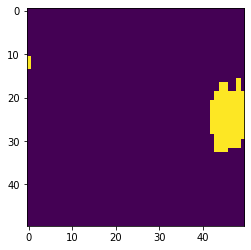

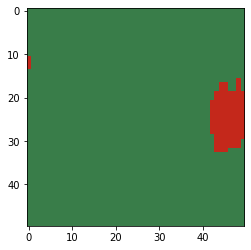

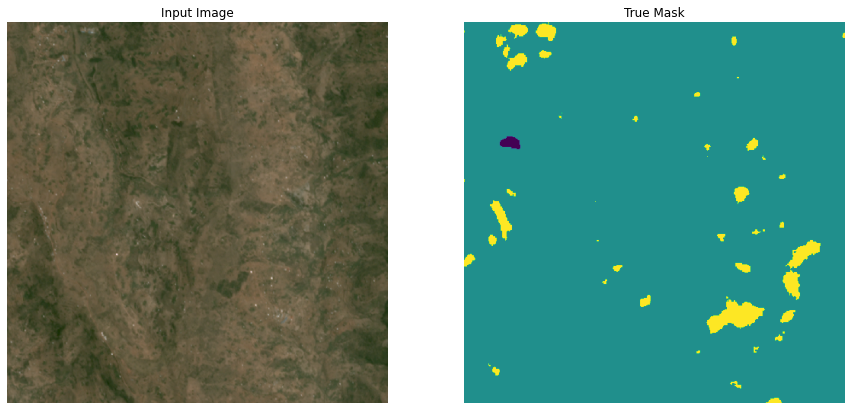

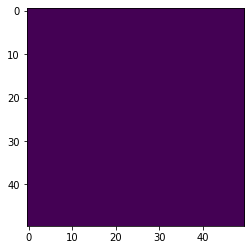

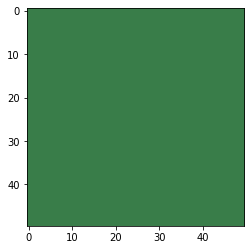

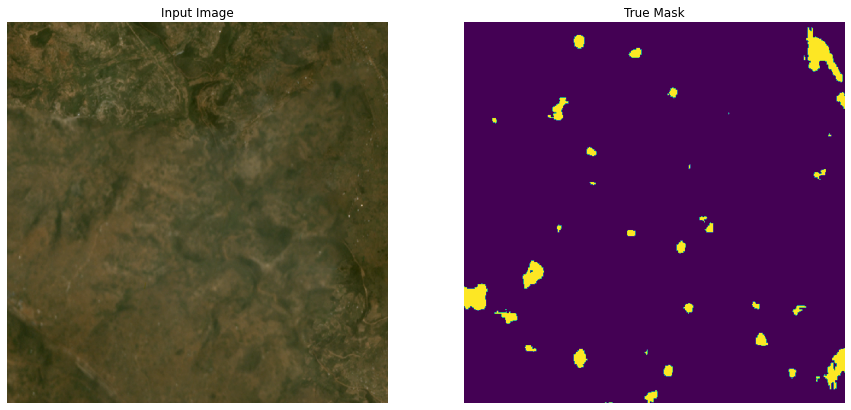

In [117]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for images, masks in train_ds.take(2):
  sample_image, sample_mask = images[0], masks[0]
  new_mask = np.zeros((50,50,3), dtype = 'uint8')
  plt.imshow(tf.keras.utils.array_to_img(tf.slice(sample_mask, begin = [0,0,0], size = [50,50,1])))
  plt.show()
  for i in range(50):
    for j in range(50):
      if sample_mask[i][j] == 0:
        new_mask[i,j,:] = 65, 155, 223
      if sample_mask[i][j] == 1:
        new_mask[i,j,:] = 57, 125, 73
      if sample_mask[i][j] == 2:
        new_mask[i,j,:] = 196, 40, 27
  plt.imshow(new_mask)
  plt.show()
  display([sample_image, sample_mask])

In [152]:
def load_image(input_image, input_mask):
  input_image = tf.image.resize(input_image, (128, 128))
  input_mask = tf.image.resize(input_mask, (128, 128))

  #input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask


new_train_ds = normalized_train_ds.map(lambda x, y: (load_image(x[0],x[1]), y))
new_val_ds = normalized_val_ds.map(lambda x, y: (load_image(x[0],x[1]), y))

In [159]:
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
first_label = labels_batch[0]
print(first_image.shape)
first_label.shape

(128, 128, 3)


TensorShape([128, 128, 1])

In [172]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [173]:
from tensorflow_examples.models.pix2pix import pix2pix
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [174]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [175]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [176]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [206]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([1.0, 4.5, 0.5])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [210]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

EPOCHS = 10
#VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(normalized_val_ds.map(add_sample_weights), epochs=EPOCHS, validation_data=normalized_train_ds)

Epoch 1/10
8/8 [==============================] - 37s 5s/step - loss: 0.1187 - accuracy: 0.7147 - val_loss: 0.5096 - val_accuracy: 0.7826
Epoch 2/10
8/8 [==============================] - 37s 5s/step - loss: 0.0997 - accuracy: 0.7149 - val_loss: 0.4445 - val_accuracy: 0.8260
Epoch 3/10
8/8 [==============================] - 39s 5s/step - loss: 0.0954 - accuracy: 0.7161 - val_loss: 0.3782 - val_accuracy: 0.8569
Epoch 4/10
8/8 [==============================] - 37s 5s/step - loss: 0.0933 - accuracy: 0.7190 - val_loss: 0.3554 - val_accuracy: 0.8688
Epoch 5/10
8/8 [==============================] - 36s 5s/step - loss: 0.0886 - accuracy: 0.7275 - val_loss: 0.3578 - val_accuracy: 0.8711
Epoch 6/10
8/8 [==============================] - 39s 5s/step - loss: 0.0887 - accuracy: 0.7252 - val_loss: 0.3399 - val_accuracy: 0.8754
Epoch 7/10
8/8 [==============================] - 38s 5s/step - loss: 0.0849 - accuracy: 0.7345 - val_loss: 0.3357 - val_accuracy: 0.8766
Epoch 8/10
8/8 [==================

In [211]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=normalized_train_ds, num=10):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 2s 2s/step


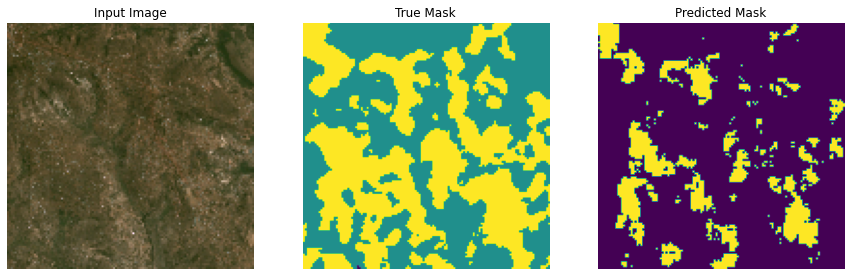

1/1 [==============================] - 2s 2s/step


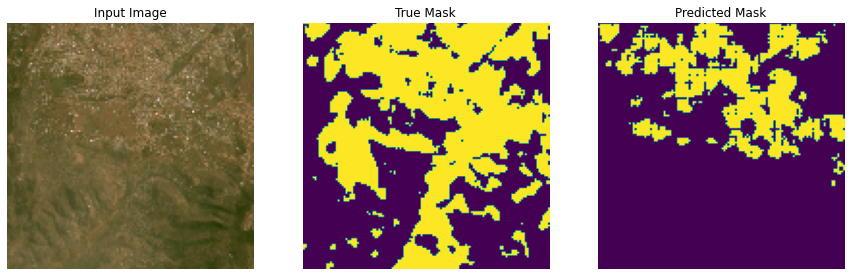

1/1 [==============================] - 2s 2s/step


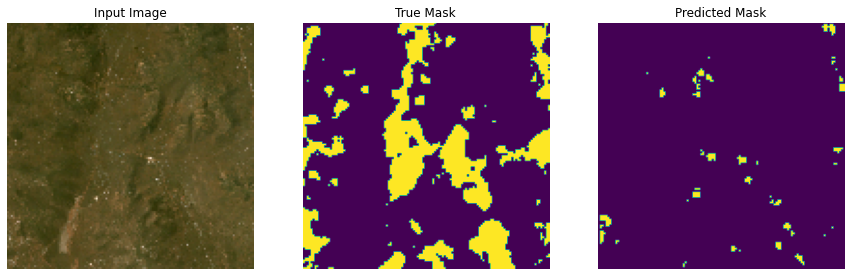

1/1 [==============================] - 2s 2s/step


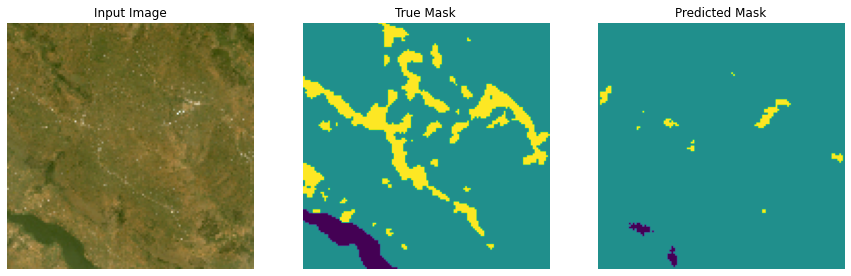

1/1 [==============================] - 1s 1s/step


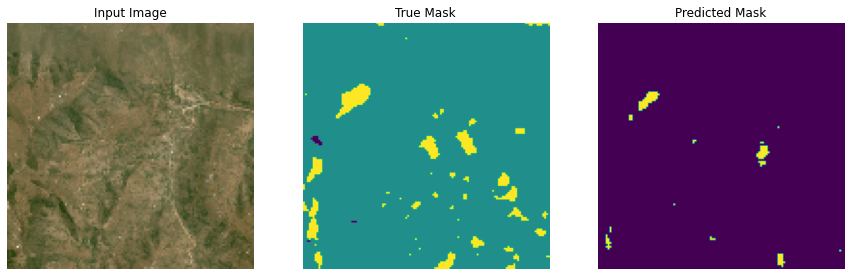

1/1 [==============================] - 2s 2s/step


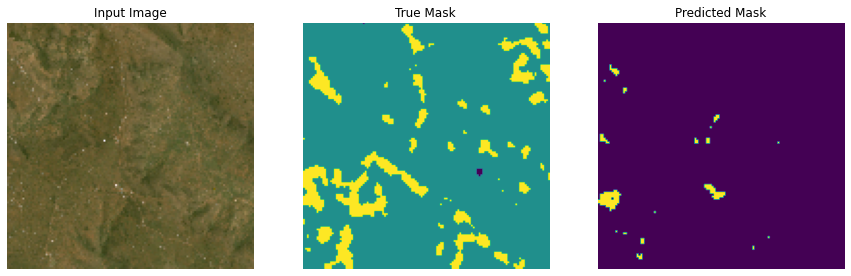

1/1 [==============================] - 2s 2s/step


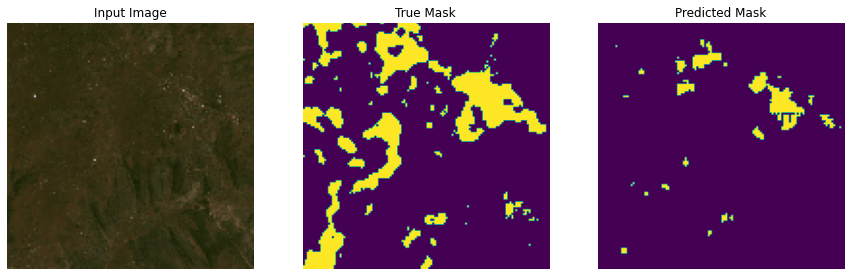

1/1 [==============================] - 2s 2s/step


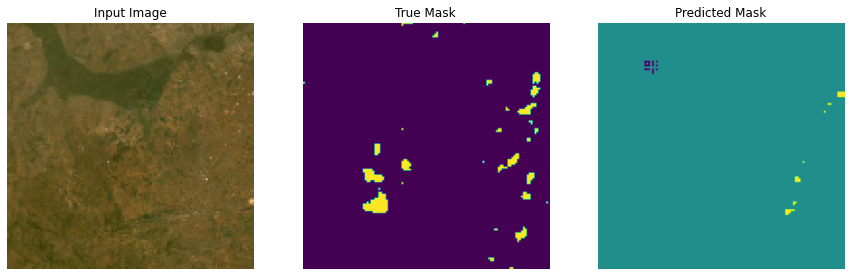

In [212]:
show_predictions()

In [202]:
#!mkdir "gdrive/MyDrive/UNET/models"
model.save('gdrive/MyDrive/UNET/models/model_trial_1')

mkdir: cannot create directory ‘gdrive/MyDrive/UNET/models’: File exists


In [ ]:
from sklearn.metrics import classification_report
i = 0
precision_list_land = []
recall_list_land = []

precision_list_trees = []
recall_list_trees = []

precision_list_water = []
recall_list_water = []

precision_list_weighted = []
recall_list_weighted = []

accuracy_overall = []

for image, mask in normalized_train_ds.take(8):
  pred_mask = model.predict(image)
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  mask = tf.reshape(mask, (32,128*128))
  pred_mask = tf.reshape(pred_mask, (32,128*128))
  for j in range(32):
    mask_im = np.array(mask[j])
    pred_mask_im = np.array(pred_mask[j])

    report = classification_report(mask_im, pred_mask_im, output_dict=True)
    try:
      precision_list_land.append(report['2.0']['precision'])
    except:
      pass
    try:
      precision_list_trees.append(report['1.0']['precision'])
    except:
      pass
    try:
      precision_list_water.append(report['0.0']['precision'])
    except:
      pass


    try:
      recall_list_land.append(report['2.0']['recall'])
    except:
      pass
    try:
      recall_list_trees.append(report['1.0']['recall'])
    except:
      pass
    try:
      recall_list_water.append(report['0.0']['recall'])
    except:
      pass
    
    accuracy_overall.append(report['accuracy'])

In [249]:
from statistics import mean
print("Average Impervios Precision:", mean(precision_list_land)*100)
print("Average Impervios Recall:", mean(recall_list_land)*100)
print("Average Tree Canopy Precision:", mean(precision_list_trees)*100)
print("Average Tree Canopy Recall:", mean(recall_list_trees)*100)
print("Average Water Precision:", mean(precision_list_water)*100)
print("Average Water Recall:", mean(recall_list_water)*100)
print("Average Accuracy:", mean(accuracy_overall)*100)

Average Impervios Precision: 77.84409972531627
Average Impervios Recall: 18.2445658491074
Average Tree Canopy Precision: 86.28070590351132
Average Tree Canopy Recall: 99.17090451949471
Average Water Precision: 33.82232491966193
Average Water Recall: 15.296894128081481
Average Accuracy: 87.34927177429199


In [250]:
model.save("gdrive/MyDrive/UNET/models/model_trial_2")

In [15]:
def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image

In [97]:
model = tf.keras.models.load_model("gdrive/MyDrive/UNET/models/model_trial_2")

In [19]:
b = tf.expand_dims(normalize(a),0)
print(b.shape)
c = model.predict(b)

(1, 128, 128, 3)
1/1 [==============================] - 2s 2s/step


In [24]:
pred_c = tf.math.argmax(c, axis=-1)

In [25]:
pred_c.shape

TensorShape([1, 128, 128])

In [29]:
new_pred_c = tf.reshape(pred_c, (128,128))

In [59]:
def convert_mask_image(mask):
  rgb_image = np.zeros((128,128,3), dtype = "uint8")
  land_cords = np.array(tf.where(mask == 2))
  water_cords = np.array(tf.where(mask == 0))
  tree_cords = np.array(tf.where(mask == 1))

  for i in range(len(land_cords)):
    #print(land_cords[i][0],land_cords[i][1])
    rgb_image[land_cords[i][0],land_cords[i][1],:3] = 196, 40, 27
  
  for i in range(len(water_cords)):
    rgb_image[water_cords[i][0],water_cords[i][1],:3] = 65, 155, 223
  
  for i in range(len(tree_cords)):
    rgb_image[tree_cords[i][0],tree_cords[i][1],:3] = 57, 125, 73
  
  return rgb_image

In [60]:
k = convert_mask_image(new_pred_c)

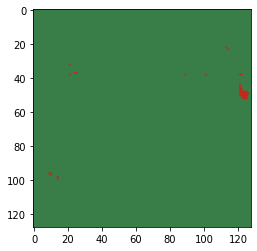

In [61]:
import matplotlib.pyplot as plt
plt.imshow(k)

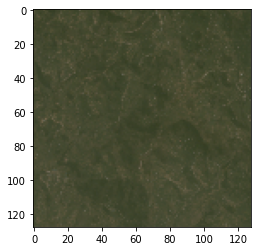

In [62]:
plt.imshow(normalize(a))

In [95]:
# Manual Validation
def convert_image_to_mask(file_str_green, file_str_red):

  green_label = np.load(file_str_green)
  #green_label_tf = tf.convert_to_tensor(green_label)
  #green_cords = tf.where(green_label_tf == 255)

  red_label = np.load(file_str_red)
  #red_label_tf = tf.convert_to_tensor(red_label)
  #red_cords = tf.where(red_label_tf == 255)

  if green_label.shape == red_label.shape:
    new_image = np.zeros((green_label.shape[0], green_label.shape[1]))
  else:
    print("shape mismatch")

  #print(green_label)
  #print(red_label)
  new_image[green_label == 255] = 1
  new_image[red_label == 255] = 2
  new_image[new_image == 0] = 1
  '''
  for i in range(len(green_cords)):
    new_image[np.array(green_cords)[i][0], np.array(green_cords)[i][1]] = 1
  
  for i in range(len(red_cords)):
    new_image[np.array(red_cords)[i][0], np.array(green_cords)[i][1]] = 2'''
  
  return new_image

In [96]:
image_00 = convert_image_to_mask("gdrive/MyDrive/UNET/validation_np/0_0_green_msk.npy", "gdrive/MyDrive/UNET/validation_np/0_0_red_msk.npy")
image_01 = convert_image_to_mask("gdrive/MyDrive/UNET/validation_np/0_1_green_msk.npy", "gdrive/MyDrive/UNET/validation_np/0_1_red_msk.npy")
image_02 = convert_image_to_mask("gdrive/MyDrive/UNET/validation_np/0_2_green_msk.npy", "gdrive/MyDrive/UNET/validation_np/0_2_red_msk.npy")
image_03 = convert_image_to_mask("gdrive/MyDrive/UNET/validation_np/0_3_green_msk.npy", "gdrive/MyDrive/UNET/validation_np/0_3_red_msk.npy")
image_12 = convert_image_to_mask("gdrive/MyDrive/UNET/validation_np/1_2_green_msk.npy", "gdrive/MyDrive/UNET/validation_np/1_2_red_msk.npy")

In [101]:
import cv2
image_00_resized = cv2.resize(image_00, (128,128))
image_01_resized = cv2.resize(image_01, (128,128))
image_02_resized = cv2.resize(image_02, (128,128))
image_03_resized = cv2.resize(image_03, (128,128))
image_12_resized = cv2.resize(image_12, (128,128))

In [122]:
image_00_list = np.reshape(image_00_resized, 128*128).astype('int16')
image_01_list = np.reshape(image_01_resized, 128*128).astype('int16')
image_02_list = np.reshape(image_02_resized, 128*128).astype('int16')
image_03_list = np.reshape(image_03_resized, 128*128).astype('int16')
image_12_list = np.reshape(image_12_resized, 128*128).astype('int16')

In [128]:
precision_list_land_val_dw = []
precision_list_trees_val_dw = []

recall_list_land_val_dw = []
recall_list_trees_val_dw = []

accuracy_val_dw = []

precision_list_land_val_pred = []
precision_list_trees_val_pred = []

recall_list_land_val_pred = []
recall_list_trees_val_pred = []

accuracy_val_pred = []

In [146]:
st_image = val_samples[18]
st_image_tf = tf.convert_to_tensor(st_image)
st_image_tf = tf.expand_dims(normalize(st_image_tf),0)

pred = model.predict(st_image_tf)
pred = tf.math.argmax(pred, axis=-1)
pred = tf.reshape(pred, (128,128))
pred_list = np.array(tf.reshape(pred, 128*128))

1/1 [==============================] - 0s 65ms/step


In [147]:
#Dynamic world labels
dw_image = val_labels[18]
dw_list = np.reshape(dw_image, 128*128)

In [148]:
from sklearn.metrics import classification_report

report = classification_report(image_12_list, dw_list, output_dict=True)

precision_list_trees_val_dw.append(report['1']['precision'])
precision_list_land_val_dw.append(report['2']['precision'])

recall_list_trees_val_dw.append(report['1']['recall'])
recall_list_land_val_dw.append(report['2']['recall'])

accuracy_val_dw.append(report['accuracy'])

In [149]:
report = classification_report(image_03_list, pred_list, output_dict=True)

precision_list_trees_val_pred.append(report['1']['precision'])
precision_list_land_val_pred.append(report['2']['precision'])

recall_list_trees_val_pred.append(report['1']['recall'])
recall_list_land_val_pred.append(report['2']['recall'])

accuracy_val_pred.append(report['accuracy'])

In [151]:
from statistics import mean
print("Dynamic vs Ground label Average Impervios Precision:", mean(precision_list_land_val_dw)*100)
print("Dynamic vs Ground label Average Impervios Recall:", mean(recall_list_land_val_dw)*100)
print("Dynamic vs Ground label Average Tree Canopy Precision:", mean(precision_list_trees_val_dw)*100)
print("Dynamic vs Ground label Average Tree Canopy Recall:", mean(recall_list_trees_val_dw)*100)
print("Dynamic vs Ground label Average Accuracy:", mean(accuracy_val_dw)*100)

Dynamic vs Ground label Average Impervios Precision: 27.778050128267456
Dynamic vs Ground label Average Impervios Recall: 22.43841295509316
Dynamic vs Ground label Average Tree Canopy Precision: 80.84043920927935
Dynamic vs Ground label Average Tree Canopy Recall: 84.78192229393451
Dynamic vs Ground label Average Accuracy: 72.15087890625


In [152]:
from statistics import mean
print("Prediction vs Ground label Average Impervios Precision:", mean(precision_list_land_val_pred)*100)
print("Prediction vs Ground label Average Impervios Recall:", mean(recall_list_land_val_pred)*100)
print("Prediction vs Ground label Average Tree Canopy Precision:", mean(precision_list_trees_val_pred)*100)
print("Prediction vs Ground label Average Tree Canopy Recall:", mean(recall_list_trees_val_pred)*100)
print("Prediction vs Ground label Average Accuracy:", mean(accuracy_val_pred)*100)

Prediction vs Ground label Average Impervios Precision: 37.716794334441396
Prediction vs Ground label Average Impervios Recall: 0.26542655293948275
Prediction vs Ground label Average Tree Canopy Precision: 77.36032780488758
Prediction vs Ground label Average Tree Canopy Recall: 99.89803110656342
Prediction vs Ground label Average Accuracy: 77.318115234375
